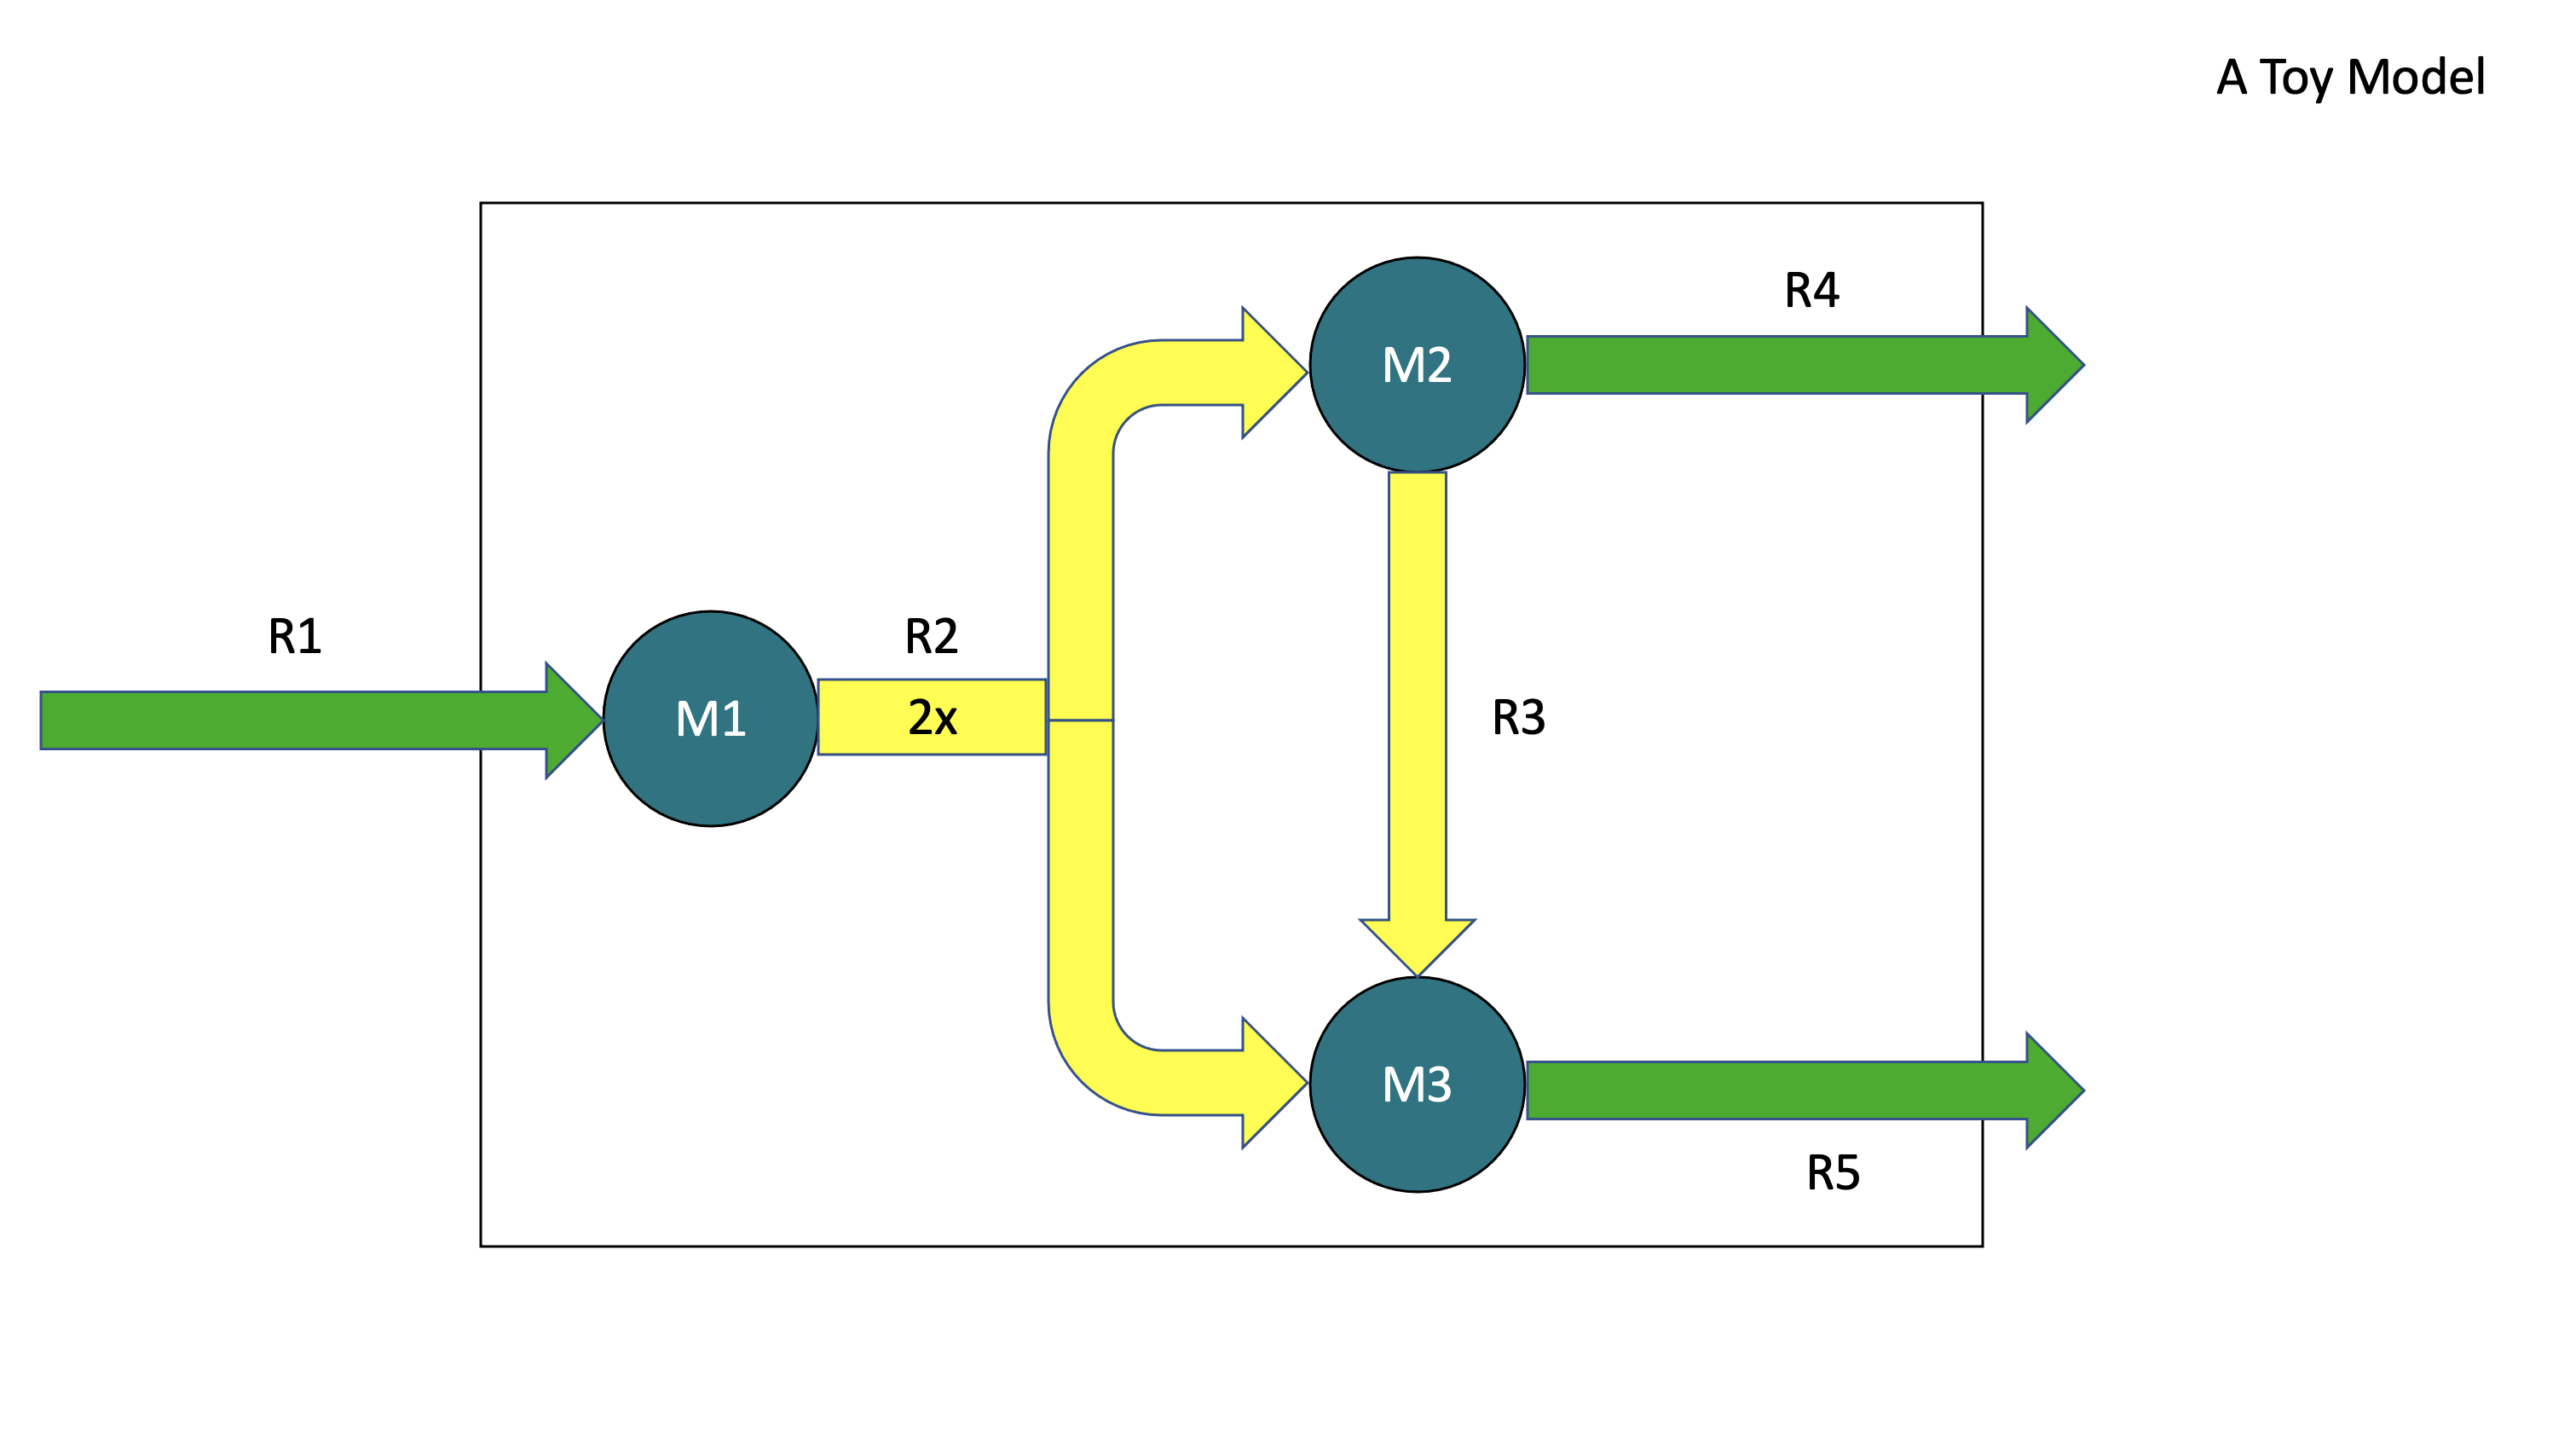

## Import Packages

In [1]:
using Distributed

# Add worker processes to the Julia distributed computing environment:
addprocs(7)

## Import Libraries

# A Toolkit of Functions for Preprocessing Metabolic Network Data:
include("../src/Data Processing/pre_processing.jl")

# Identifying Blocked Reactions in a Metabolic Model using Linear Optimization:
include("../src/Consistency Checking/TheNaiveApproach.jl")

# Identifying blocked reactions in metabolic networks using linear programming(1LP) and Gaussian elimination:
@everywhere include("../src/Consistency Checking/SwiftCC.jl")

# Parallel computation of quantitative flux coupling using swiftCC algorithm and Gaussian elimination:
@everywhere include("../src/QFCA/distributedQFCA.jl")

# Import required Julia modules:
using .pre_processing, .TheNaiveApproach, .SwiftCC, .DistributedQFCA, COBREXA, JuMP, sparseQFCA



                   //    |
        \\\\\  // //     | COBREXA.jl  v1.4.0
         \\ \\// //      |
          \\ \/ //       | COnstraint-Based Reconstruction
           \\  //        | and EXascale Analysis in Julia
           //  \\        |
          // /\ \\       | See documentation and examples at:
         // //\\ \\      | https://lcsb-biocore.github.io/COBREXA.jl
        // //  \\\\\     |
       //                |
        


## Distributed computing environment

In [2]:
println("Number of Workers : $(nprocs())")

Number of Workers : 8


## Reconstruct a TestModel

In [15]:
model = StandardModel("TestModel") 
gene_list = [Gene(string("g", num)) for num = 1:5]
add_genes!(model, gene_list)
metabolite_list = [Metabolite(string("m", num)) for num = 1:3]

# r1 : Exchange m1
# r2 : m1 ---> m2 + m3
# r3 : m2 ---> m3
# r4 : Exchange m2
# r5 : Exchange m3

add_metabolites!(model, metabolite_list)
r1 = Reaction("r1", Dict("m1" => 1.0), :forward)
r2 = Reaction("r2", Dict("m1" => -2.0, "m2" => 1.0,  "m3" => 1.0), :forward)
r3 = Reaction("r3", Dict("m2" => -1.0, "m3" => 1.0), :forward)
r4 = Reaction("r4", Dict("m2" => -1.0), :forward)
r5 = Reaction("r5", Dict("m3" => -1.0), :forward)

add_reactions!(model, [r1, r2, r3, r4, r5])


# Flux Coupling Analysis (FCA)


For each pairs of reactions, $j_1$ and $j_2$, five possible coupling cases is imaginable:


0. Uncoupled: $R_{min} = 0, R_{max} = \infty$
1. Fully Coupled ($v_i \Leftrightarrow v_j$): $R_{min} = R_{max} = c > 0$ , $[v_i = c v_j,\quad\forall v \in \mathcal{C}]$ 
2. Partially Coupled ($v_i \leftrightarrow v_j$): $R_{min} = c_1 > 0, R_{max} = c_2 > 0$ , $[v_i \neq 0 \Leftrightarrow v_j \neq 0,\quad\forall v \in \mathcal{C}]$
3. Directionally Coupled ($v_i \rightarrow v_j$): $R_{min} = 0, R_{max} = c > 0$ , $[v_i \neq 0 \Rightarrow v_j \neq 0,\quad\forall v \in \mathcal{C}]$
4. Directionally Coupled ($v_i \leftarrow v_j$): $R_{min} = c > 0, R_{max} = \infty$ , $v_j \neq 0 \Rightarrow v_i \neq 0,\quad\forall v \in \mathcal{C}$

# distributedQFCA

- `fctable`:               
                               The resulting flux coupling matrix.
                               The meaning of the entry (i, j) is:
                                    * 0 - uncoupled reactions
                                    * 1 - fully coupled reactions
                                    * 2 - partially coupled reactions
                                    * 3 - reaction i is directionally coupled to reaction j
                                    * 4 - reaction j is directionally coupled to reaction i
- `Fc_Coefficients`:           
                               A list of fully-coupling coefficients. 
- `Dc_Coefficients`:          
                               A list of DCE (directional coupling equation) coefficients.

In [5]:
fctable, Fc_Coefficients, Dc_Coefficients = distributedQFCA(model)
println()

Number of Metabolites : 3
Number of Reactions   : 5
Number of Genes       : 5
Stoichiometric matrix : 3 x 5
Number of irreversible reactions : 5 
Number of reversibe    reactions : 0 
M = 1.0e6
Tolerance = 1.0e-6
Consistency_Checking(SwiftCC):
Number of irreversible blocked reactions : 0
Number of reversible   blocked reactions : 0
Number of blocked reactions              : 0
Number of reversibe blocked in forward  direction : 0
Number of reversibe blocked in backward direction : 0
Number of irreversible reactions after Correction : 5
Number of reversible   reactions after Correction : 0
Quantitative Flux Coupling Analysis(distributedQFCA):
Final fctable : 
Number of 0's (unCoupled) : 2
Number of 1's (Fully)     : 7
Number of 2's (Partialy)  : 4
Number of 3's (DC i-->j)  : 6
Number of 4's (DC j-->i)  : 6



## Flux Coupling Table

In [8]:
println("fctable : ")
display(fctable)

fctable : 


5×5 SharedArrays.SharedMatrix{Int64}:
 1  1  4  4  2
 1  1  4  4  2
 3  3  1  0  3
 3  3  0  1  3
 2  2  4  4  1

## FC_Coefficients

In [12]:
println("FC_Coefficients : ")
display(Fc_Coefficients)

FC_Coefficients : 


5×5 SharedArrays.SharedMatrix{Float64}:
 1.0  2.0  0.0  0.0  0.0
 0.5  1.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  1.0

$R_{1} = 2R_{2}$
\
$0.5R_{1} = R_{2}$

# Quantitative FCA (QFCA)

**DCE Theorem:** In a network without any irreversible blocked reaction, for an arbitrary reaction $R_j$, if $D_j$ is the non-empty set of all the irreversible reactions directionally coupled to $R_j$ (excluding itself), there exists positive coefficients $\{c_d\}_{d: R_d \in D_j}$ such that:

$$
v_j = \sum_{d: R_d \in D_j} c_d v_d
$$ 

 ## DC_Coefficients

In [13]:
println("DC_Coefficients : ")
display(Dc_Coefficients)

DC_Coefficients : 


5×5 SharedArrays.SharedMatrix{Float64}:
  2.0  -1.0  -1.0  -2.0  -1.0
 -1.0   5.0  -1.0  -2.0  -1.0
  0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0
 -1.0  -1.0  -5.0  -1.0   4.0

$2R_{1} = R_{2} + R_{3} + 2R_{4} + R_{5}$
\
$5R_{2} = R_{1} + R_{3} + 2R_{4} + R_{5}$
\
$4R_{5} = R_{1} + R_{2} + 5R_{3} + R_{4}$

## Mass Balances

#### M1:
$R_{1} = 2R_{2}$

#### M2:
$R_{2} = R_{3} + R_{4}$

#### M3:
$R_{2} + R_{3} = R_{5}$

## Extended DCEs

 


#### DCE_1:
$R_{1} = R_{4} + R_{5}$$\rightarrow$$2R_{2} = R_{4} + R_{5}$

#### DCE_2(M1,M2):
1.$R_{1} = 2R_{2}$
\
2.$R_{2} = R_{3} + R_{4}$
\
1,2$\rightarrow$$0.5R_{1} = R_{3} + R_{4}$

#### DCE_3(M1,M3):
1.$R_{1} = 2R_{2}$
\
2.$R_{2} + R_{3} = R_{5}$
\
1,2$\rightarrow$$0.5R_{1} + R_{3} = R_{5}$

#### DCE_4(M2,M3):
1.$R_{2} = R_{3} + R_{4}$
\
2.$R_{2} + R_{3} = R_{5}$
\
1,2$\rightarrow$$R_{5} = 2R_{3} + R_{4}$